# <span style="color: crimson">Прогноз ухода клиента из банка</span>
---  
**<span style="color: crimson">Заказчик</span>**: банк «Бета-Банка».  
**<span style="color: crimson">Цель анализа</span>**: спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.    
**<span style="color: crimson">Датасет</span>**: исторические данные о поведении клиентов и расторжении договоров с банком. 

**Источник данных:** [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


---

<h3>Описание данных:</h3>  
<h4 style="color:crimson"> Признаки </h4>
    
* **RowNumber** — индекс строки в данных
* **CustomerId** — уникальный идентификатор клиента
* **Surname** — фамилия
* **CreditScore** — кредитный рейтинг
* **Geography** — страна проживания
* **Gender** — пол
* **Age** — возраст
* **Tenure** — сколько лет человек является клиентом банка
* **Balance** — баланс на счёте
* **NumOfProducts** — количество продуктов банка, используемых клиентом
* **HasCrCard** — наличие кредитной карты
* **IsActiveMember** — активность клиента
* **EstimatedSalary** — предполагаемая зарплата

<h4 style="color:crimson"> Целевой признак </h4>

* **Exited** — факт ухода клиента

---

<h2> Импорт библиотек: </h2>

In [1]:
!pip3 install optuna

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, metrics
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.utils import shuffle
import optuna

In [3]:
import pandas as pd
pd.options.display.float_format ='{:,.2f}'.format # Округление на 2 знаке после запятой

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## <span style="color: crimson">Этап 1</span> Изучение данных

In [4]:
df = pd.read_csv('./Churn.csv')

In [5]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
RowNumber,1,2,3,4,5,6,7,8,9,10
CustomerId,15634602,15647311,15619304,15701354,15737888,15574012,15592531,15656148,15792365,15592389
Surname,Hargrave,Hill,Onio,Boni,Mitchell,Chu,Bartlett,Obinna,He,H?
CreditScore,619,608,502,699,850,645,822,376,501,684
Geography,France,Spain,France,France,Spain,Spain,France,Germany,France,France
Gender,Female,Female,Female,Female,Female,Male,Male,Female,Male,Male
Age,42,41,42,39,43,44,50,29,44,27
Tenure,2.00,1.00,8.00,1.00,2.00,8.00,7.00,4.00,4.00,2.00
Balance,0.00,"83,807.86","159,660.80",0.00,"125,510.82","113,755.78",0.00,"115,046.74","142,051.07","134,603.88"
NumOfProducts,1,1,3,2,1,2,2,4,2,1


По описанию и представленному набору данных можно понять, что для создания модели нам нужны не все признаки, излишние  только повредят качеству предсказания, так что: 
1. <font color='red'>Удалим столбцы RowNumber, CustomerId, Surname</font> (индивидуальные идентификаторы пользователя).
2. <font color='red'>Так же стоит кодируем столбцы Geography, Gender из категориальных в численные.</font>

<h4 style="color:crimson">Общая информация:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<h4 style="color:crimson">Глянем на столбец с пропусками:

In [7]:
sorted(df['Tenure'].unique())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]

**Типы данных:**  
 Изменять тип данных на int нет смысла, так как мы будем применять масштабирование.

**Пропуски:**  
 По данным сложно понять, причину возникновения  пропусков.
 Заполним пропуски в tenure (сколько лет человек является клиентом банка) -1.

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,"10,000.00","5,000.50","2,886.90",1.00,"2,500.75","5,000.50","7,500.25","10,000.00"
CustomerId,"10,000.00","15,690,940.57","71,936.19","15,565,701.00","15,628,528.25","15,690,738.00","15,753,233.75","15,815,690.00"
CreditScore,"10,000.00",650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,"10,000.00",38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,"9,091.00",5.00,2.89,0.00,2.00,5.00,7.00,10.00
Balance,"10,000.00","76,485.89","62,397.41",0.00,0.00,"97,198.54","127,644.24","250,898.09"
NumOfProducts,"10,000.00",1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,"10,000.00",0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,"10,000.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,"10,000.00","100,090.24","57,510.49",11.58,"51,002.11","100,193.91","149,388.25","199,992.48"


Ничего интересного.

<h4 style="color:crimson"> Поиск полных дубликатов:

In [9]:
df.duplicated().sum()

0

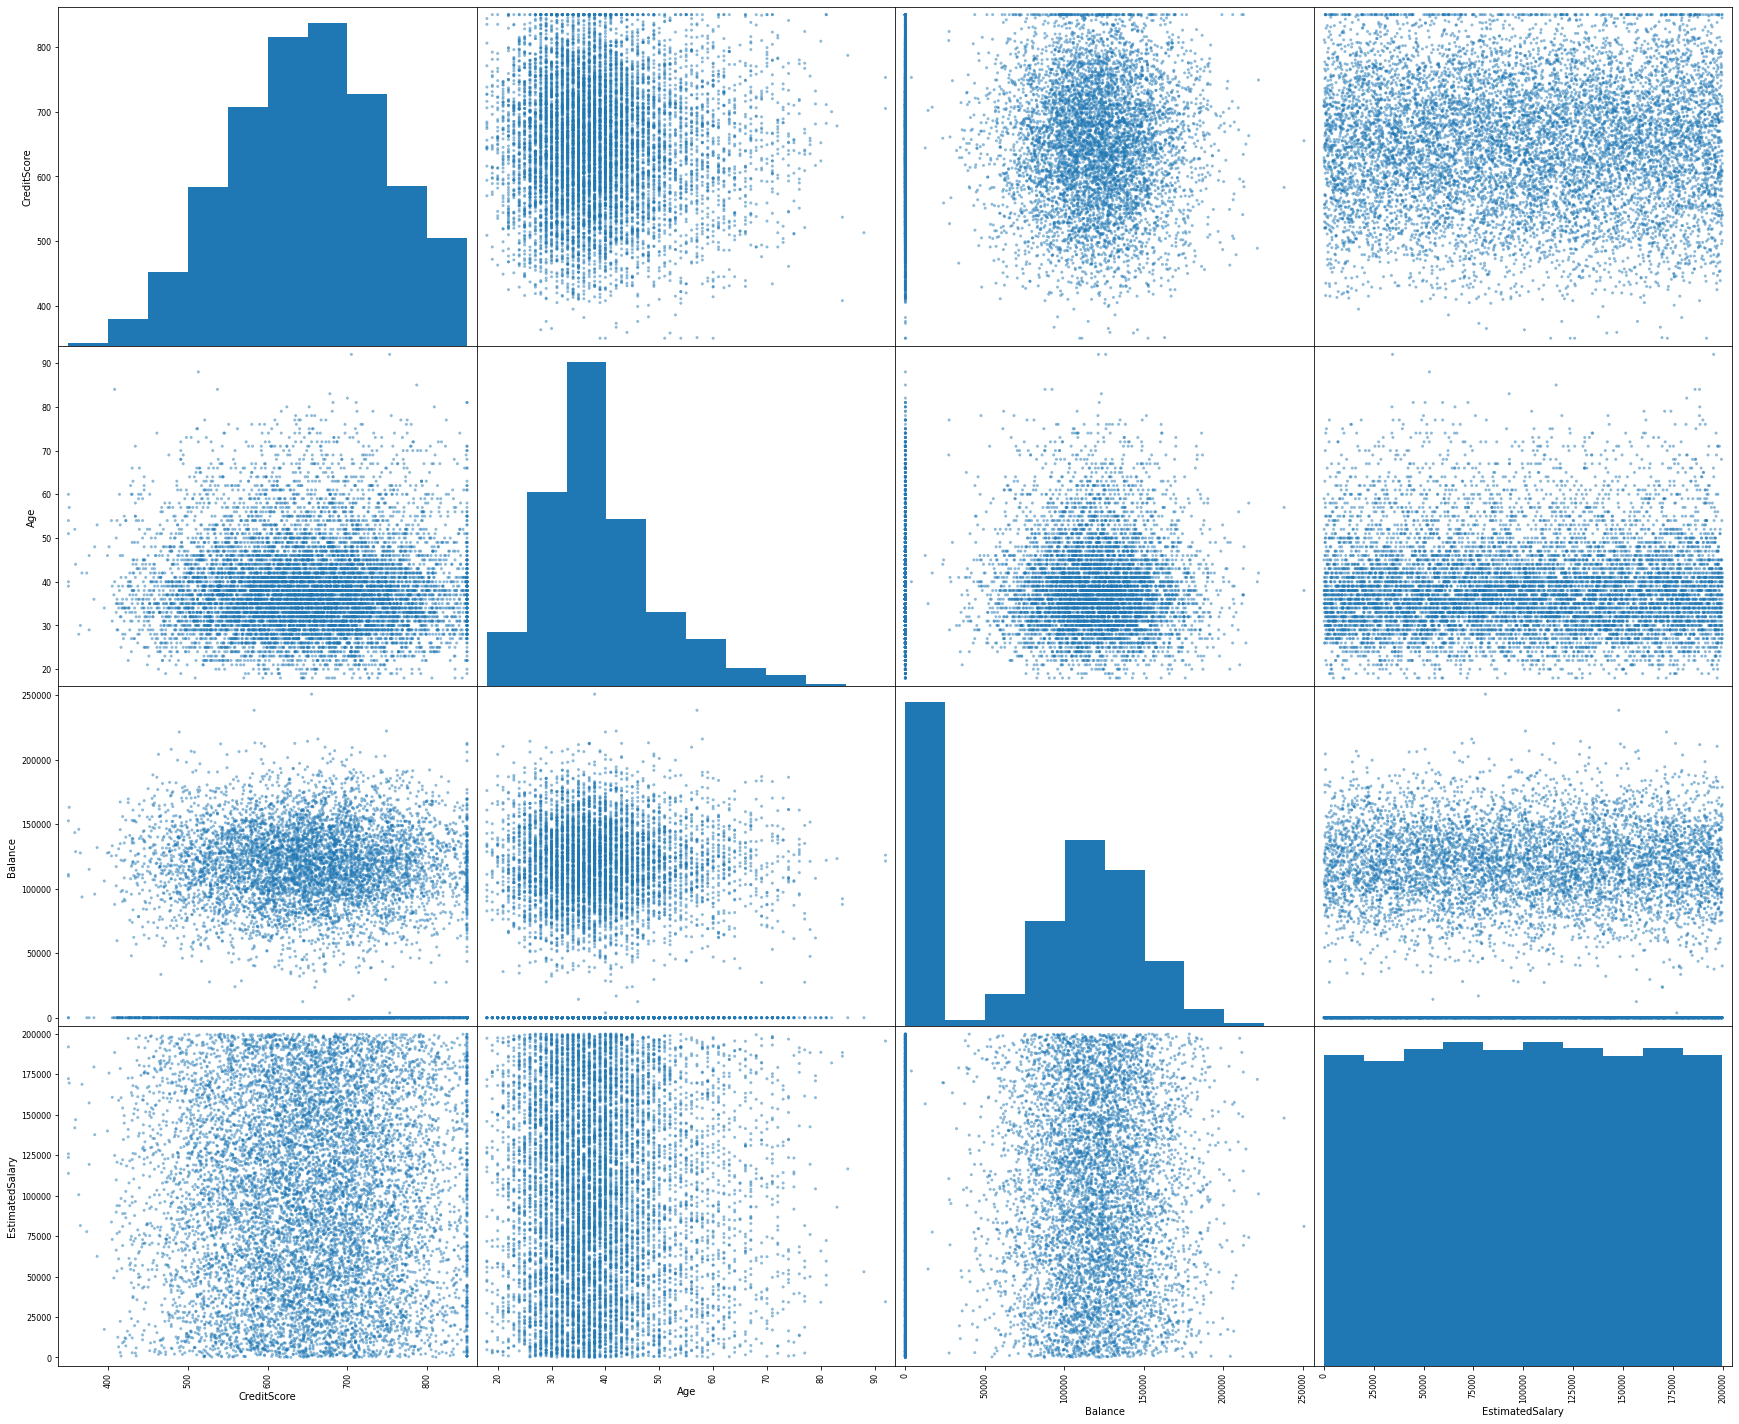

In [10]:
corr_col = ['CreditScore', 'Gender', 'Age', 'Balance', 'EstimatedSalary']

pd.plotting.scatter_matrix(df[corr_col],figsize=(30,25));

В данных есть корреляции, но не сильно выраженные, хотя и имеются определеные признаки влияющие на распределение (кредитный рейтинг, возраст и баланс).

### <center><span style="color: crimson"><b>Вывод</b></span></center>
1. Данные имеют избыточный характер (лишние столбцы).
2. Пропуски в столбцах в Tenure должны быть заменены на -1 т.к. модель не может работать с пропусками, и значение (сколько лет человек является клиентом банка.) не может быть отрицательным.
3. Категориальные столбы (Geography, Gender) должны быть кодированы из категориальных в численные.

---

## <span style="color: crimson">Этап 2</span> Предобработка данных

**<span style="color: crimson">Удаление</span>  столбцов:**

In [11]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

**Обработка <span style="color: crimson">пропусков</span>:**

In [12]:
df['Tenure'] = df['Tenure'].fillna(value=-1)

**<span style="color: crimson">Кодирование</span> категориальных данных:**

Так как в Geography, Gender значения категориальные, а не порядковые используем One Hot Encoding.

In [13]:
df = pd.get_dummies(df, drop_first=True)

**<span style="color:crimson">Масштабирование</span>:**

In [14]:
num_columns = [
    "CreditScore",
    "Tenure",
    "Age",
    "Balance",
    "NumOfProducts",
    "EstimatedSalary",
]

scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])

### <center><span style="color: crimson"><b>Вывод</b></span></center>
На первом этапе **проведены анализ и пред обработка данных**.

* **Не найдено интересных корреляций** между параметрами.

* **Обработаны пропуски**

* **Числовые данные отмасштабированы** (приведены к единой шкале измерения)

* **Качественные от кодированы** (переведены в числовые).

* **Данные были разбиты на тренировочные, валидационные и тестовые**.

----

 ## <span style="color: crimson">Этап 3</span>  Анализ

#### Анализ дисбаланса

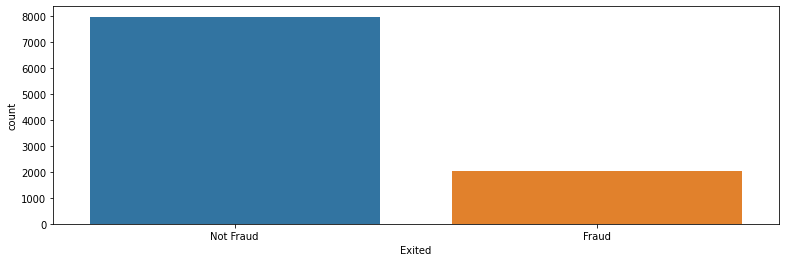

In [15]:
plt.figure(figsize=(13,4))

all_df = sns.countplot(df['Exited'])

all_df.set_xticklabels(['Not Fraud','Fraud'])

plt.show();

### <center><span style="color: crimson"><b>Вывод</b></span></center>  
Дисбаланс имеется во всем наборе данных (примерно 1/4).  

**Способы решения:**
1. Игнорирование.
2. Балансировка.
3. Изменение веса классов при обучении модели.

---

## <span style="color: crimson">Этап 4</span> Разбиение данных на выборки

#### Разбиение данных на выборки

In [16]:
train, valid = train_test_split(df, test_size=0.2, random_state=666)
valid, test = train_test_split(valid, test_size=0.5, random_state=666)


features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']

features_valid = valid.drop(['Exited'], axis=1)
target_valid = valid['Exited']

features_test = test.drop(['Exited'], axis=1)
target_test = test['Exited']

### <span style="color: crimson"> Борьба</span> с дисбалансом (Resampling) 

####  - Уменьшение выборки (<span style="color: crimson">downsample</span>)

In [17]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_down = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1234)] + [features_ones])
    target_down = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1234)] + [target_ones])
    
    features_down, target_down = shuffle(features_down, target_down, random_state=1234)
    
    return features_down, target_down

In [18]:
features_train_down, target_train_down = downsample(features_train, target_train, 0.25)

target_train_down.reset_index()['Exited'].value_counts()

1    1644
0    1589
Name: Exited, dtype: int64

#### - Увеличение выборки (<span style="color: crimson">upsampling</span> )

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [20]:
features_train_ups, target_train_ups = upsample(features_train, target_train, 4)

target_train_ups.reset_index()['Exited'].value_counts()

1    6576
0    6356
Name: Exited, dtype: int64

### <center><span style="color: crimson"><b>Вывод</b></span></center>  
Данные подготовлены для обучения, необработанные и подвергнутые ресемплингу.

---

## <span style="color: crimson">Этап 5</span>  Создание и тестирование моделей 

### **Используемые модели:**
* Градиентный бустинг классификации
* Случайный лес
* Логистическая регрессия

**Настройка optuma**

In [21]:
RANDOM_SEED = 666

kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

### <span style="color: crimson">1.</span> Градиентный бустинг классификации

In [22]:
def test_model_GBC(features, target):
    def objective(trial):
        param = {
            "learning_rate": trial.suggest_float("learning_rate", 0.00001, 1.0),
            "max_depth": trial.suggest_int("max_depth", 1, 5),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
            "max_features": trial.suggest_float("max_features", 0.01, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 1, 100)
        }

        model = GradientBoostingClassifier(**param)
        model.fit(features, target) 
        scores = f1_score(target_valid, model.predict(features_valid))  

        return scores


    GBC_params = tune(objective)
    model_GBC = GradientBoostingClassifier(**GBC_params, random_state=RANDOM_SEED)

    model_GBC.fit(features, target) 

    A_GBC = model_GBC.score(features_test, target_test) 
    F_GBC = f1_score(target_test, model_GBC.predict(features_test))  

    print("Accuracy модели {}".format(A_GBC))
    print("F1_score модели {}".format(F_GBC))
    return model_GBC.predict(features_test)

In [23]:
GBC = test_model_GBC(features_train, target_train)

[I 2022-03-22 23:54:51,773] A new study created in memory with name: no-name-5f06ad92-c0b5-44d3-a7f1-afe2bdc095bf
[I 2022-03-22 23:54:52,029] Trial 0 finished with value: 0.6237942122186496 and parameters: {'learning_rate': 0.5453766537838948, 'max_depth': 2, 'min_samples_leaf': 50, 'max_features': 0.7406560702225258, 'n_estimators': 61}. Best is trial 0 with value: 0.6237942122186496.
[I 2022-03-22 23:54:52,490] Trial 1 finished with value: 0.604361370716511 and parameters: {'learning_rate': 0.24231654545468825, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 0.8332176587247108, 'n_estimators': 44}. Best is trial 0 with value: 0.6237942122186496.
[I 2022-03-22 23:54:52,936] Trial 2 finished with value: 0.5798816568047338 and parameters: {'learning_rate': 0.7972229225715679, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 0.9655064041637507, 'n_estimators': 39}. Best is trial 0 with value: 0.6237942122186496.
[I 2022-03-22 23:54:53,197] Trial 3 finished with value: 0.6465

[I 2022-03-22 23:54:59,335] Trial 29 finished with value: 0.6056782334384858 and parameters: {'learning_rate': 0.3112294731994849, 'max_depth': 5, 'min_samples_leaf': 34, 'max_features': 0.8208756250978375, 'n_estimators': 40}. Best is trial 3 with value: 0.6465256797583082.
[I 2022-03-22 23:54:59,925] Trial 30 finished with value: 0.6084142394822006 and parameters: {'learning_rate': 0.11262875341173428, 'max_depth': 4, 'min_samples_leaf': 21, 'max_features': 0.6923543654438369, 'n_estimators': 89}. Best is trial 3 with value: 0.6465256797583082.
[I 2022-03-22 23:55:00,291] Trial 31 finished with value: 0.6230529595015577 and parameters: {'learning_rate': 0.7925509435275122, 'max_depth': 2, 'min_samples_leaf': 8, 'max_features': 0.8887000375977261, 'n_estimators': 78}. Best is trial 3 with value: 0.6465256797583082.
[I 2022-03-22 23:55:00,566] Trial 32 finished with value: 0.6253869969040247 and parameters: {'learning_rate': 0.7635898464215279, 'max_depth': 2, 'min_samples_leaf': 17, '

[I 2022-03-22 23:55:07,433] Trial 58 finished with value: 0.6020066889632106 and parameters: {'learning_rate': 0.7690477513655456, 'max_depth': 1, 'min_samples_leaf': 32, 'max_features': 0.6838869836215025, 'n_estimators': 74}. Best is trial 3 with value: 0.6465256797583082.
[I 2022-03-22 23:55:07,779] Trial 59 finished with value: 0.6 and parameters: {'learning_rate': 0.5277546476947456, 'max_depth': 5, 'min_samples_leaf': 27, 'max_features': 0.5424795477249031, 'n_estimators': 53}. Best is trial 3 with value: 0.6465256797583082.
[I 2022-03-22 23:55:08,114] Trial 60 finished with value: 0.61875 and parameters: {'learning_rate': 0.5651242543995542, 'max_depth': 2, 'min_samples_leaf': 36, 'max_features': 0.7883201588708726, 'n_estimators': 79}. Best is trial 3 with value: 0.6465256797583082.
[I 2022-03-22 23:55:08,503] Trial 61 finished with value: 0.5864197530864197 and parameters: {'learning_rate': 0.7903665433006123, 'max_depth': 2, 'min_samples_leaf': 8, 'max_features': 0.8980705806

[I 2022-03-22 23:55:15,152] Trial 87 finished with value: 0.6158940397350994 and parameters: {'learning_rate': 0.3372318302298299, 'max_depth': 2, 'min_samples_leaf': 39, 'max_features': 0.9417756977575547, 'n_estimators': 24}. Best is trial 3 with value: 0.6465256797583082.
[I 2022-03-22 23:55:15,394] Trial 88 finished with value: 0.6204620462046205 and parameters: {'learning_rate': 0.23399258274535595, 'max_depth': 2, 'min_samples_leaf': 25, 'max_features': 0.9025261543250602, 'n_estimators': 51}. Best is trial 3 with value: 0.6465256797583082.
[I 2022-03-22 23:55:15,746] Trial 89 finished with value: 0.6196319018404907 and parameters: {'learning_rate': 0.6514937443765328, 'max_depth': 5, 'min_samples_leaf': 30, 'max_features': 0.8623081323226287, 'n_estimators': 32}. Best is trial 3 with value: 0.6465256797583082.
[I 2022-03-22 23:55:15,947] Trial 90 finished with value: 0.6056782334384858 and parameters: {'learning_rate': 0.6094581438946637, 'max_depth': 3, 'min_samples_leaf': 34, 

Best score: 0.6465256797583082

Optimized parameters: {'learning_rate': 0.6314046293864506, 'max_depth': 5, 'min_samples_leaf': 33, 'max_features': 0.4549324248269562, 'n_estimators': 41}

Accuracy модели 0.846
F1_score модели 0.5722222222222222


In [24]:
GBC_DOWN = test_model_GBC(features_train_down, target_train_down)

[I 2022-03-22 23:55:18,013] A new study created in memory with name: no-name-4d501def-4872-4666-91ca-aa2d0380fc67
[I 2022-03-22 23:55:18,041] Trial 0 finished with value: 0.5606361829025844 and parameters: {'learning_rate': 0.35797147159656323, 'max_depth': 5, 'min_samples_leaf': 48, 'max_features': 0.5490345557613968, 'n_estimators': 4}. Best is trial 0 with value: 0.5606361829025844.
[I 2022-03-22 23:55:18,139] Trial 1 finished with value: 0.5346534653465347 and parameters: {'learning_rate': 0.7705092868494318, 'max_depth': 4, 'min_samples_leaf': 13, 'max_features': 0.06347098905122736, 'n_estimators': 65}. Best is trial 0 with value: 0.5606361829025844.
[I 2022-03-22 23:55:18,199] Trial 2 finished with value: 0.5918367346938775 and parameters: {'learning_rate': 0.2775144124445986, 'max_depth': 4, 'min_samples_leaf': 44, 'max_features': 0.390215065916764, 'n_estimators': 24}. Best is trial 2 with value: 0.5918367346938775.
[I 2022-03-22 23:55:18,252] Trial 3 finished with value: 0.57

[I 2022-03-22 23:55:20,802] Trial 28 finished with value: 0.585858585858586 and parameters: {'learning_rate': 0.24821987261719808, 'max_depth': 3, 'min_samples_leaf': 31, 'max_features': 0.8950541379915046, 'n_estimators': 36}. Best is trial 24 with value: 0.6004140786749482.
[I 2022-03-22 23:55:20,922] Trial 29 finished with value: 0.5766129032258064 and parameters: {'learning_rate': 0.406684724906766, 'max_depth': 2, 'min_samples_leaf': 48, 'max_features': 0.7303324184519766, 'n_estimators': 57}. Best is trial 24 with value: 0.6004140786749482.
[I 2022-03-22 23:55:20,951] Trial 30 finished with value: 0.5672268907563025 and parameters: {'learning_rate': 0.5576863959632887, 'max_depth': 1, 'min_samples_leaf': 34, 'max_features': 0.8894489704504719, 'n_estimators': 9}. Best is trial 24 with value: 0.6004140786749482.
[I 2022-03-22 23:55:20,979] Trial 31 finished with value: 0.5701754385964912 and parameters: {'learning_rate': 0.2064663892348204, 'max_depth': 3, 'min_samples_leaf': 38, 

[I 2022-03-22 23:55:23,837] Trial 57 finished with value: 0.587991718426501 and parameters: {'learning_rate': 0.10651078491996513, 'max_depth': 2, 'min_samples_leaf': 11, 'max_features': 0.39727316816129604, 'n_estimators': 82}. Best is trial 24 with value: 0.6004140786749482.
[I 2022-03-22 23:55:23,973] Trial 58 finished with value: 0.5860655737704917 and parameters: {'learning_rate': 0.1867397265012692, 'max_depth': 2, 'min_samples_leaf': 4, 'max_features': 0.524530769734332, 'n_estimators': 85}. Best is trial 24 with value: 0.6004140786749482.
[I 2022-03-22 23:55:24,074] Trial 59 finished with value: 0.5362035225048923 and parameters: {'learning_rate': 0.023617616191655144, 'max_depth': 1, 'min_samples_leaf': 6, 'max_features': 0.48106332343068653, 'n_estimators': 96}. Best is trial 24 with value: 0.6004140786749482.
[I 2022-03-22 23:55:24,248] Trial 60 finished with value: 0.5938144329896907 and parameters: {'learning_rate': 0.09758587858835317, 'max_depth': 2, 'min_samples_leaf': 

[I 2022-03-22 23:55:28,707] Trial 86 finished with value: 0.5884773662551439 and parameters: {'learning_rate': 0.08590061933340838, 'max_depth': 2, 'min_samples_leaf': 8, 'max_features': 0.5811365327907076, 'n_estimators': 84}. Best is trial 85 with value: 0.6061855670103093.
[I 2022-03-22 23:55:28,892] Trial 87 finished with value: 0.6045548654244306 and parameters: {'learning_rate': 0.1426942533463636, 'max_depth': 2, 'min_samples_leaf': 5, 'max_features': 0.9116883047704851, 'n_estimators': 78}. Best is trial 85 with value: 0.6061855670103093.
[I 2022-03-22 23:55:29,081] Trial 88 finished with value: 0.5978947368421054 and parameters: {'learning_rate': 0.047433411247291446, 'max_depth': 2, 'min_samples_leaf': 5, 'max_features': 0.9804196329304572, 'n_estimators': 79}. Best is trial 85 with value: 0.6061855670103093.
[I 2022-03-22 23:55:29,281] Trial 89 finished with value: 0.5945945945945946 and parameters: {'learning_rate': 0.06322897721121704, 'max_depth': 2, 'min_samples_leaf': 1

Best score: 0.6096033402922756

Optimized parameters: {'learning_rate': 0.09953827136313452, 'max_depth': 2, 'min_samples_leaf': 12, 'max_features': 0.8778628957694191, 'n_estimators': 91}

Accuracy модели 0.783
F1_score модели 0.5834932821497121


In [25]:
GBC_UPS = test_model_GBC(features_train_ups, target_train_ups)

[I 2022-03-22 23:55:31,450] A new study created in memory with name: no-name-39fee831-f8ac-427d-8522-801e43faa081
[I 2022-03-22 23:55:31,821] Trial 0 finished with value: 0.5835010060362174 and parameters: {'learning_rate': 0.7540586585053318, 'max_depth': 1, 'min_samples_leaf': 34, 'max_features': 0.9506594016683447, 'n_estimators': 87}. Best is trial 0 with value: 0.5835010060362174.
[I 2022-03-22 23:55:31,843] Trial 1 finished with value: 0.4318766066838047 and parameters: {'learning_rate': 0.036750114504154635, 'max_depth': 1, 'min_samples_leaf': 28, 'max_features': 0.07212908620111295, 'n_estimators': 10}. Best is trial 0 with value: 0.5835010060362174.
[I 2022-03-22 23:55:31,888] Trial 2 finished with value: 0.4983164983164983 and parameters: {'learning_rate': 0.3598210367425651, 'max_depth': 1, 'min_samples_leaf': 4, 'max_features': 0.08437749856000268, 'n_estimators': 26}. Best is trial 0 with value: 0.5835010060362174.
[I 2022-03-22 23:55:31,982] Trial 3 finished with value: 0

[I 2022-03-22 23:55:40,105] Trial 28 finished with value: 0.5902335456475584 and parameters: {'learning_rate': 0.5595227533920252, 'max_depth': 3, 'min_samples_leaf': 35, 'max_features': 0.7110653405353413, 'n_estimators': 78}. Best is trial 9 with value: 0.5961945031712473.
[I 2022-03-22 23:55:41,563] Trial 29 finished with value: 0.5793103448275863 and parameters: {'learning_rate': 0.7396526457180046, 'max_depth': 4, 'min_samples_leaf': 21, 'max_features': 0.9930402911226452, 'n_estimators': 100}. Best is trial 9 with value: 0.5961945031712473.
[I 2022-03-22 23:55:42,154] Trial 30 finished with value: 0.5935483870967743 and parameters: {'learning_rate': 0.7679244771186812, 'max_depth': 5, 'min_samples_leaf': 45, 'max_features': 0.90110940431876, 'n_estimators': 37}. Best is trial 9 with value: 0.5961945031712473.
[I 2022-03-22 23:55:42,758] Trial 31 finished with value: 0.5789473684210528 and parameters: {'learning_rate': 0.7995462472931711, 'max_depth': 5, 'min_samples_leaf': 44, 'm

[I 2022-03-22 23:55:56,652] Trial 57 finished with value: 0.5933609958506224 and parameters: {'learning_rate': 0.37932565797551565, 'max_depth': 2, 'min_samples_leaf': 30, 'max_features': 0.9674406711094887, 'n_estimators': 80}. Best is trial 37 with value: 0.6169772256728778.
[I 2022-03-22 23:55:57,305] Trial 58 finished with value: 0.6063157894736841 and parameters: {'learning_rate': 0.45525868884463183, 'max_depth': 3, 'min_samples_leaf': 27, 'max_features': 0.8819515921624616, 'n_estimators': 65}. Best is trial 37 with value: 0.6169772256728778.
[I 2022-03-22 23:55:57,975] Trial 59 finished with value: 0.594017094017094 and parameters: {'learning_rate': 0.4553536874734911, 'max_depth': 3, 'min_samples_leaf': 23, 'max_features': 0.9922592534739689, 'n_estimators': 65}. Best is trial 37 with value: 0.6169772256728778.
[I 2022-03-22 23:55:58,315] Trial 60 finished with value: 0.6000000000000001 and parameters: {'learning_rate': 0.5269728420465972, 'max_depth': 2, 'min_samples_leaf': 2

[I 2022-03-22 23:56:13,427] Trial 86 finished with value: 0.5953878406708596 and parameters: {'learning_rate': 0.4317412007803165, 'max_depth': 3, 'min_samples_leaf': 28, 'max_features': 0.43195919905021446, 'n_estimators': 75}. Best is trial 64 with value: 0.6176470588235294.
[I 2022-03-22 23:56:13,828] Trial 87 finished with value: 0.5664488017429194 and parameters: {'learning_rate': 0.4945607656384502, 'max_depth': 4, 'min_samples_leaf': 48, 'max_features': 0.29767962439852, 'n_estimators': 70}. Best is trial 64 with value: 0.6176470588235294.
[I 2022-03-22 23:56:14,207] Trial 88 finished with value: 0.5867768595041322 and parameters: {'learning_rate': 0.4080964737638793, 'max_depth': 3, 'min_samples_leaf': 25, 'max_features': 0.5484528680953458, 'n_estimators': 53}. Best is trial 64 with value: 0.6176470588235294.
[I 2022-03-22 23:56:14,688] Trial 89 finished with value: 0.6058091286307054 and parameters: {'learning_rate': 0.3762999020734241, 'max_depth': 3, 'min_samples_leaf': 2, 

Best score: 0.6176470588235294

Optimized parameters: {'learning_rate': 0.2923848143561325, 'max_depth': 3, 'min_samples_leaf': 34, 'max_features': 0.8833650667390696, 'n_estimators': 66}

Accuracy модели 0.787
F1_score модели 0.5958254269449714


### <center><span style="color: crimson"><b>Вывод</b></span></center>  

Наилучшее качество (**0.61**) при использовании **GradientBoostingClassifier** показывает upsampling.

---

### <span style="color: crimson">2.</span> Случайный лес

In [26]:
def test_model_RF(features, target):
    def objective(trial):
        param = {
            "max_depth": trial.suggest_int("max_depth", 1, 100),
            'n_estimators': trial.suggest_int("n_estimators", 1, 500),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
            'max_leaf_nodes': trial.suggest_int("max_leaf_nodes", 10, 100)
        }

        model_RF = RandomForestClassifier(**param)
        model_RF.fit(features, target) 
        scores = f1_score(target_valid, model_RF.predict(features_valid))  

        return scores


    RF_params = tune(objective)
    model_RF = RandomForestClassifier(**RF_params, random_state=RANDOM_SEED)
    model_RF.fit(features, target) 

    A_RF = model_RF.score(features_test, target_test) 
    F_RF = f1_score(target_test, model_RF.predict(features_test))  

    print("Accuracy модели {}".format(A_RF))
    print("F1_score модели {}".format(F_RF))
    return model_RF.predict(features_test)

**Используем данные с ребалансировкой и без неё**

In [27]:
RF = test_model_RF(features_train, target_train)

[I 2022-03-22 23:56:21,235] A new study created in memory with name: no-name-3688d976-0fd2-46d8-86cf-1a1f8a2159e3
[I 2022-03-22 23:56:21,288] Trial 0 finished with value: 0.5519713261648747 and parameters: {'max_depth': 86, 'n_estimators': 11, 'min_samples_leaf': 1, 'max_leaf_nodes': 41}. Best is trial 0 with value: 0.5519713261648747.
[I 2022-03-22 23:56:21,694] Trial 1 finished with value: 0.6020761245674741 and parameters: {'max_depth': 37, 'n_estimators': 95, 'min_samples_leaf': 5, 'max_leaf_nodes': 86}. Best is trial 1 with value: 0.6020761245674741.
[I 2022-03-22 23:56:22,643] Trial 2 finished with value: 0.5936395759717314 and parameters: {'max_depth': 56, 'n_estimators': 241, 'min_samples_leaf': 4, 'max_leaf_nodes': 49}. Best is trial 1 with value: 0.6020761245674741.
[I 2022-03-22 23:56:24,349] Trial 3 finished with value: 0.5944055944055945 and parameters: {'max_depth': 43, 'n_estimators': 412, 'min_samples_leaf': 7, 'max_leaf_nodes': 74}. Best is trial 1 with value: 0.602076

[I 2022-03-22 23:56:50,013] Trial 34 finished with value: 0.5964912280701755 and parameters: {'max_depth': 46, 'n_estimators': 238, 'min_samples_leaf': 3, 'max_leaf_nodes': 44}. Best is trial 13 with value: 0.6041666666666667.
[I 2022-03-22 23:56:50,760] Trial 35 finished with value: 0.5993031358885017 and parameters: {'max_depth': 90, 'n_estimators': 174, 'min_samples_leaf': 4, 'max_leaf_nodes': 90}. Best is trial 13 with value: 0.6041666666666667.
[I 2022-03-22 23:56:52,233] Trial 36 finished with value: 0.5964912280701755 and parameters: {'max_depth': 70, 'n_estimators': 345, 'min_samples_leaf': 3, 'max_leaf_nodes': 74}. Best is trial 13 with value: 0.6041666666666667.
[I 2022-03-22 23:56:54,133] Trial 37 finished with value: 0.5993031358885017 and parameters: {'max_depth': 35, 'n_estimators': 441, 'min_samples_leaf': 5, 'max_leaf_nodes': 89}. Best is trial 13 with value: 0.6041666666666667.
[I 2022-03-22 23:56:54,778] Trial 38 finished with value: 0.5944055944055945 and parameters:

[I 2022-03-22 23:57:17,131] Trial 69 finished with value: 0.6111111111111112 and parameters: {'max_depth': 91, 'n_estimators': 97, 'min_samples_leaf': 2, 'max_leaf_nodes': 52}. Best is trial 69 with value: 0.6111111111111112.
[I 2022-03-22 23:57:17,668] Trial 70 finished with value: 0.5886524822695035 and parameters: {'max_depth': 89, 'n_estimators': 132, 'min_samples_leaf': 1, 'max_leaf_nodes': 46}. Best is trial 69 with value: 0.6111111111111112.
[I 2022-03-22 23:57:18,068] Trial 71 finished with value: 0.5886524822695035 and parameters: {'max_depth': 92, 'n_estimators': 97, 'min_samples_leaf': 2, 'max_leaf_nodes': 51}. Best is trial 69 with value: 0.6111111111111112.
[I 2022-03-22 23:57:18,821] Trial 72 finished with value: 0.6013986013986015 and parameters: {'max_depth': 97, 'n_estimators': 184, 'min_samples_leaf': 2, 'max_leaf_nodes': 58}. Best is trial 69 with value: 0.6111111111111112.
[I 2022-03-22 23:57:19,580] Trial 73 finished with value: 0.5915492957746479 and parameters: {

Best score: 0.6111111111111112

Optimized parameters: {'max_depth': 91, 'n_estimators': 97, 'min_samples_leaf': 2, 'max_leaf_nodes': 52}

Accuracy модели 0.852
F1_score модели 0.5316455696202531


In [28]:
RF_DOWN = test_model_RF(features_train_down, target_train_down) 

[I 2022-03-22 23:57:37,288] A new study created in memory with name: no-name-13bf1e25-b0b5-4050-aaff-d5e49f027e84
[I 2022-03-22 23:57:37,732] Trial 0 finished with value: 0.5840000000000001 and parameters: {'max_depth': 49, 'n_estimators': 191, 'min_samples_leaf': 7, 'max_leaf_nodes': 42}. Best is trial 0 with value: 0.5840000000000001.
[I 2022-03-22 23:57:38,264] Trial 1 finished with value: 0.5915492957746479 and parameters: {'max_depth': 37, 'n_estimators': 228, 'min_samples_leaf': 5, 'max_leaf_nodes': 66}. Best is trial 1 with value: 0.5915492957746479.
[I 2022-03-22 23:57:38,748] Trial 2 finished with value: 0.588 and parameters: {'max_depth': 76, 'n_estimators': 194, 'min_samples_leaf': 7, 'max_leaf_nodes': 88}. Best is trial 1 with value: 0.5915492957746479.
[I 2022-03-22 23:57:39,521] Trial 3 finished with value: 0.593186372745491 and parameters: {'max_depth': 61, 'n_estimators': 311, 'min_samples_leaf': 5, 'max_leaf_nodes': 99}. Best is trial 3 with value: 0.593186372745491.
[

[I 2022-03-22 23:57:57,545] Trial 35 finished with value: 0.5776892430278884 and parameters: {'max_depth': 35, 'n_estimators': 354, 'min_samples_leaf': 4, 'max_leaf_nodes': 20}. Best is trial 28 with value: 0.6.
[I 2022-03-22 23:57:57,943] Trial 36 finished with value: 0.5811623246492985 and parameters: {'max_depth': 45, 'n_estimators': 170, 'min_samples_leaf': 4, 'max_leaf_nodes': 57}. Best is trial 28 with value: 0.6.
[I 2022-03-22 23:57:58,655] Trial 37 finished with value: 0.5908183632734532 and parameters: {'max_depth': 61, 'n_estimators': 317, 'min_samples_leaf': 5, 'max_leaf_nodes': 40}. Best is trial 28 with value: 0.6.
[I 2022-03-22 23:57:59,301] Trial 38 finished with value: 0.592 and parameters: {'max_depth': 52, 'n_estimators': 264, 'min_samples_leaf': 2, 'max_leaf_nodes': 76}. Best is trial 28 with value: 0.6.
[I 2022-03-22 23:57:59,920] Trial 39 finished with value: 0.5805168986083499 and parameters: {'max_depth': 74, 'n_estimators': 256, 'min_samples_leaf': 1, 'max_leaf_

[I 2022-03-22 23:58:20,812] Trial 72 finished with value: 0.5765407554671969 and parameters: {'max_depth': 11, 'n_estimators': 286, 'min_samples_leaf': 3, 'max_leaf_nodes': 86}. Best is trial 28 with value: 0.6.
[I 2022-03-22 23:58:21,628] Trial 73 finished with value: 0.5828343313373253 and parameters: {'max_depth': 46, 'n_estimators': 325, 'min_samples_leaf': 2, 'max_leaf_nodes': 91}. Best is trial 28 with value: 0.6.
[I 2022-03-22 23:58:22,272] Trial 74 finished with value: 0.5877712031558184 and parameters: {'max_depth': 32, 'n_estimators': 264, 'min_samples_leaf': 1, 'max_leaf_nodes': 92}. Best is trial 28 with value: 0.6.
[I 2022-03-22 23:58:22,873] Trial 75 finished with value: 0.5753968253968254 and parameters: {'max_depth': 19, 'n_estimators': 249, 'min_samples_leaf': 4, 'max_leaf_nodes': 72}. Best is trial 28 with value: 0.6.
[I 2022-03-22 23:58:23,652] Trial 76 finished with value: 0.5806451612903225 and parameters: {'max_depth': 27, 'n_estimators': 348, 'min_samples_leaf': 

Best score: 0.6

Optimized parameters: {'max_depth': 47, 'n_estimators': 322, 'min_samples_leaf': 6, 'max_leaf_nodes': 35}

Accuracy модели 0.77
F1_score модели 0.5660377358490566


In [29]:
RF_UPS = test_model_RF(features_train_ups, target_train_ups)

[I 2022-03-22 23:58:41,560] A new study created in memory with name: no-name-d2f51211-d6c2-403e-971b-074fc536ce9f
[I 2022-03-22 23:58:41,927] Trial 0 finished with value: 0.5810276679841898 and parameters: {'max_depth': 64, 'n_estimators': 68, 'min_samples_leaf': 7, 'max_leaf_nodes': 17}. Best is trial 0 with value: 0.5810276679841898.
[I 2022-03-22 23:58:42,648] Trial 1 finished with value: 0.5833333333333334 and parameters: {'max_depth': 37, 'n_estimators': 134, 'min_samples_leaf': 6, 'max_leaf_nodes': 28}. Best is trial 1 with value: 0.5833333333333334.
[I 2022-03-22 23:58:43,297] Trial 2 finished with value: 0.597979797979798 and parameters: {'max_depth': 13, 'n_estimators': 104, 'min_samples_leaf': 1, 'max_leaf_nodes': 81}. Best is trial 2 with value: 0.597979797979798.
[I 2022-03-22 23:58:45,206] Trial 3 finished with value: 0.595482546201232 and parameters: {'max_depth': 69, 'n_estimators': 320, 'min_samples_leaf': 7, 'max_leaf_nodes': 63}. Best is trial 2 with value: 0.59797979

[I 2022-03-22 23:59:39,683] Trial 34 finished with value: 0.5742187499999999 and parameters: {'max_depth': 57, 'n_estimators': 2, 'min_samples_leaf': 5, 'max_leaf_nodes': 68}. Best is trial 11 with value: 0.6124999999999999.
[I 2022-03-22 23:59:40,942] Trial 35 finished with value: 0.5632183908045977 and parameters: {'max_depth': 68, 'n_estimators': 278, 'min_samples_leaf': 7, 'max_leaf_nodes': 10}. Best is trial 11 with value: 0.6124999999999999.
[I 2022-03-22 23:59:42,406] Trial 36 finished with value: 0.6070686070686071 and parameters: {'max_depth': 80, 'n_estimators': 225, 'min_samples_leaf': 9, 'max_leaf_nodes': 96}. Best is trial 11 with value: 0.6124999999999999.
[I 2022-03-22 23:59:43,052] Trial 37 finished with value: 0.5918367346938775 and parameters: {'max_depth': 81, 'n_estimators': 102, 'min_samples_leaf': 10, 'max_leaf_nodes': 80}. Best is trial 11 with value: 0.6124999999999999.
[I 2022-03-22 23:59:45,246] Trial 38 finished with value: 0.595482546201232 and parameters: {

[I 2022-03-23 00:00:26,021] Trial 69 finished with value: 0.6121593291404613 and parameters: {'max_depth': 70, 'n_estimators': 61, 'min_samples_leaf': 10, 'max_leaf_nodes': 89}. Best is trial 11 with value: 0.6124999999999999.
[I 2022-03-23 00:00:26,578] Trial 70 finished with value: 0.5938144329896907 and parameters: {'max_depth': 63, 'n_estimators': 85, 'min_samples_leaf': 10, 'max_leaf_nodes': 83}. Best is trial 11 with value: 0.6124999999999999.
[I 2022-03-23 00:00:26,824] Trial 71 finished with value: 0.5805168986083499 and parameters: {'max_depth': 69, 'n_estimators': 35, 'min_samples_leaf': 10, 'max_leaf_nodes': 89}. Best is trial 11 with value: 0.6124999999999999.
[I 2022-03-23 00:00:27,235] Trial 72 finished with value: 0.6160164271047227 and parameters: {'max_depth': 57, 'n_estimators': 62, 'min_samples_leaf': 10, 'max_leaf_nodes': 87}. Best is trial 72 with value: 0.6160164271047227.
[I 2022-03-23 00:00:27,297] Trial 73 finished with value: 0.5730994152046782 and parameters:

Best score: 0.6160164271047227

Optimized parameters: {'max_depth': 57, 'n_estimators': 62, 'min_samples_leaf': 10, 'max_leaf_nodes': 87}

Accuracy модели 0.787
F1_score модели 0.5880077369439072


**Воспользуемся методом балансировки.**

In [30]:
%%time

def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        'n_estimators': trial.suggest_int("n_estimators", 1, 100),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
        'max_leaf_nodes': trial.suggest_int("max_leaf_nodes", 10, 100)
}

    model_RF = RandomForestClassifier(**param, class_weight='balanced')
    model_RF.fit(features_train, target_train) 
    scores = f1_score(target_valid, model_RF.predict(features_valid))  

    return scores

RF_params = tune(objective)
model_RF = RandomForestClassifier(**RF_params, random_state=RANDOM_SEED, class_weight='balanced')
model_RF.fit(features_train, target_train)

A_RF = model_RF.score(features_test, target_test) 
F_RF = f1_score(target_test, model_RF.predict(features_test))  

print("Accuracy модели {}".format(A_RF))
print("F1_score модели {}".format(F_RF))

RF_B = model_RF.predict(features_test)

[I 2022-03-23 00:00:48,491] A new study created in memory with name: no-name-5d9a2976-b0d1-4255-8db1-b6467189d5cc
[I 2022-03-23 00:00:48,658] Trial 0 finished with value: 0.5942622950819672 and parameters: {'max_depth': 77, 'n_estimators': 37, 'min_samples_leaf': 7, 'max_leaf_nodes': 27}. Best is trial 0 with value: 0.5942622950819672.
[I 2022-03-23 00:00:48,856] Trial 1 finished with value: 0.6187363834422657 and parameters: {'max_depth': 31, 'n_estimators': 44, 'min_samples_leaf': 2, 'max_leaf_nodes': 69}. Best is trial 1 with value: 0.6187363834422657.
[I 2022-03-23 00:00:49,098] Trial 2 finished with value: 0.6098081023454158 and parameters: {'max_depth': 30, 'n_estimators': 52, 'min_samples_leaf': 6, 'max_leaf_nodes': 96}. Best is trial 1 with value: 0.6187363834422657.
[I 2022-03-23 00:00:49,374] Trial 3 finished with value: 0.5889570552147239 and parameters: {'max_depth': 69, 'n_estimators': 66, 'min_samples_leaf': 8, 'max_leaf_nodes': 41}. Best is trial 1 with value: 0.61873638

[I 2022-03-23 00:00:56,769] Trial 34 finished with value: 0.6164079822616407 and parameters: {'max_depth': 100, 'n_estimators': 64, 'min_samples_leaf': 6, 'max_leaf_nodes': 94}. Best is trial 12 with value: 0.6260869565217391.
[I 2022-03-23 00:00:57,022] Trial 35 finished with value: 0.6241758241758243 and parameters: {'max_depth': 82, 'n_estimators': 52, 'min_samples_leaf': 4, 'max_leaf_nodes': 84}. Best is trial 12 with value: 0.6260869565217391.
[I 2022-03-23 00:00:57,273] Trial 36 finished with value: 0.619047619047619 and parameters: {'max_depth': 73, 'n_estimators': 51, 'min_samples_leaf': 5, 'max_leaf_nodes': 100}. Best is trial 12 with value: 0.6260869565217391.
[I 2022-03-23 00:00:57,458] Trial 37 finished with value: 0.6191536748329621 and parameters: {'max_depth': 64, 'n_estimators': 39, 'min_samples_leaf': 4, 'max_leaf_nodes': 92}. Best is trial 12 with value: 0.6260869565217391.
[I 2022-03-23 00:00:57,918] Trial 38 finished with value: 0.6203904555314533 and parameters: {'

[I 2022-03-23 00:01:07,047] Trial 69 finished with value: 0.6177105831533477 and parameters: {'max_depth': 60, 'n_estimators': 48, 'min_samples_leaf': 2, 'max_leaf_nodes': 75}. Best is trial 42 with value: 0.6303854875283447.
[I 2022-03-23 00:01:07,426] Trial 70 finished with value: 0.611353711790393 and parameters: {'max_depth': 80, 'n_estimators': 79, 'min_samples_leaf': 1, 'max_leaf_nodes': 100}. Best is trial 42 with value: 0.6303854875283447.
[I 2022-03-23 00:01:07,714] Trial 71 finished with value: 0.6051502145922747 and parameters: {'max_depth': 90, 'n_estimators': 63, 'min_samples_leaf': 6, 'max_leaf_nodes': 79}. Best is trial 42 with value: 0.6303854875283447.
[I 2022-03-23 00:01:07,998] Trial 72 finished with value: 0.610752688172043 and parameters: {'max_depth': 80, 'n_estimators': 61, 'min_samples_leaf': 7, 'max_leaf_nodes': 84}. Best is trial 42 with value: 0.6303854875283447.
[I 2022-03-23 00:01:08,244] Trial 73 finished with value: 0.6147186147186147 and parameters: {'ma

Best score: 0.6304347826086956

Optimized parameters: {'max_depth': 93, 'n_estimators': 52, 'min_samples_leaf': 4, 'max_leaf_nodes': 78}

Accuracy модели 0.797
F1_score модели 0.5964214711729622
CPU times: total: 26 s
Wall time: 26 s


### <center><span style="color: crimson"><b>Вывод</b></span></center>  

Наилучшее качество (**0.61**) при использовании **RandomForestClassifier** показывает балансировка (class_weight).

---

### <span style="color: crimson">3.</span> Логистическая регрессия

In [31]:
def test_model_LR(features, target):
    model_LR = LogisticRegression(random_state=666) 
    model_LR.fit(features, target) 

    A_LR = model_LR.score(features_test, target_test) 
    F_LR = f1_score(target_test, model_LR.predict(features_test)) 

    print("Accuracy модели {}".format(A_LR))
    print("F1_score модели {}".format(F_LR))

**Используем данные с ребалансировкой и без неё**

In [32]:
test_model_LR(features_train, target_train)

Accuracy модели 0.797
F1_score модели 0.31186440677966104


In [33]:
test_model_LR(features_train_down, target_train_down) 

Accuracy модели 0.688
F1_score модели 0.48172757475083056


In [34]:
test_model_LR(features_train_ups, target_train_ups)

Accuracy модели 0.685
F1_score модели 0.47587354409317806


### <center><span style="color: crimson"><b>Вывод</b></span></center>  

Наилучшее качество (**0.48**) при использовании **LogisticRegression** показывает downsample.

---

## <span style="color: crimson">Этап 6</span> Анализ модели 

**Две модели показывают одинаковое качество, поэтому стоит оценить их матрицы ошибок.**

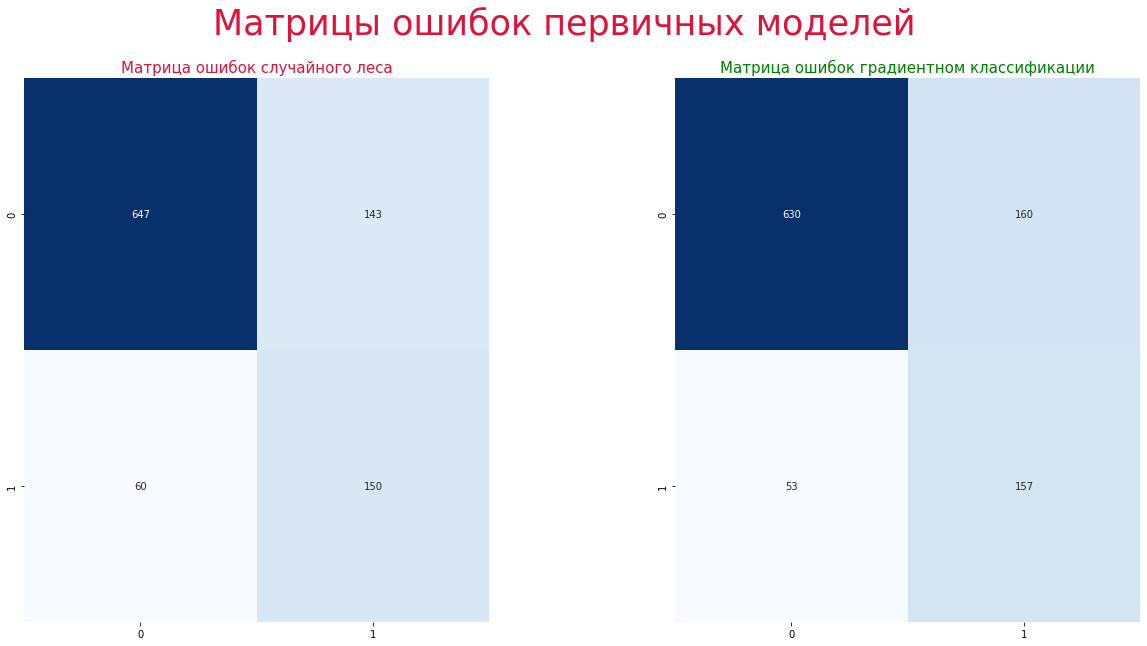

In [35]:
GBC_cm = confusion_matrix(target_test, GBC_UPS)
RF_cm = confusion_matrix(target_test, RF_B)

plt.figure(figsize=(20, 10))

plt.suptitle("Матрицы ошибок первичных моделей",fontsize=35, fontdict = {'color':'crimson'})
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)


plt.subplot(1,2,2)
plt.title("Матрица ошибок градиентном классификации",fontsize=15, fontdict = {'color':'green'})
sns.heatmap(GBC_cm,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(1,2,1)
plt.title("Матрица ошибок случайного леса",fontsize=15, fontdict = {'color':'crimson'})
sns.heatmap(RF_cm,annot=True,cmap="Blues",fmt="d",cbar=False)


plt.show()

### <center><span style="color: crimson"><b>Вывод</b></span></center>  

Нам нужно выбрать модель, что пропустит наименьшее число уходящих клиентов (ложно-положительных значений).   
Такой моделью является **случайный лес**.

-----

## <span style="color: crimson">Этап 7</span>  Общий вывод

Наиболее оптимальная модель это **случайный лес** с параметрами: 
* max_depth = 97, 
* n_estimators = 90, 
* min_samples_leaf = 9, 
* max_leaf_nodes = 100
* class_weight = 'balanced'

Метод **class_weight**  увеличил f1_score (0.07) у модели случайного леса.  
**F1_score** случайного леса на тестовой выборке показывает значение 0.634.  
Наилучший метод балансировки (в данной задаче) это **изменение веса класса**.